# Imports

In [1253]:
%matplotlib inline

import json
import math
import time
import pytz
import datetime
import cPickle as pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.regularizers import l1, l2, l1l2

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Utilities

In [1254]:
def timestamp():
    return int((datetime.datetime.now(tz=pytz.utc) - datetime.datetime(1970, 1, 1, tzinfo=pytz.utc)).total_seconds())

In [1177]:
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = 'binary'
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    # plt.colorbar(im, cax=cax)

In [513]:
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols

    plt.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

# Data

In [1439]:
f = open('output.pkl', 'rb')
(X_train, Y_train), (X_test, Y_test) = pickle.load(f)
f.close()

In [1440]:
X_train = np.array(X_train).astype("float32")
Y_train = np.array(Y_train).astype("float32")
X_test = np.array(X_test).astype("float32")
Y_test = np.array(Y_test).astype("float32")

In [1441]:
print(X_train.shape, Y_train.shape, 'train samples')
print(X_test.shape, Y_test.shape, 'test samples')

((100000, 54), (100000, 6), 'train samples')
((10000, 54), (10000, 6), 'test samples')


In [1442]:
X_train[-1]

array([ 0.        ,  0.        ,  0.        , -0.01593824, -0.21242528,
        0.45235109, -0.28093836, -0.50052226,  0.14126401, -0.94017738,
       -0.13585389,  0.03530662,  0.65536833,  0.27710766, -0.91615772,
        0.65536833,  0.27710766, -0.91615772,  0.        ,  0.        ,
        0.        , -0.03022255,  0.07216511,  0.03696203,  0.05633039,
       -0.02064238,  0.03623805,  0.01077279,  0.02801525,  0.01047907,
       -0.08309322, -0.00888562,  0.10483839, -0.08309322, -0.00888562,
        0.10483839,  0.        ,  0.        ,  0.        ,  0.03579551,
        0.06803999,  0.02946644, -0.0524323 ,  0.06402588,  0.12140159,
       -0.03849657,  0.01987715, -0.02894721, -0.03467225,  0.03455978,
        0.01653824, -0.03467225,  0.03455978,  0.01653824], dtype=float32)

In [1443]:
Y_train[-1]

array([-0.95252937, -0.86702371,  0.82813025,  0.15008143, -0.00910797,
       -0.18869388], dtype=float32)

# Model

In [1449]:
model = Sequential()
model.add(Dense(54, 256, activation='relu', init='normal'))
model.add(Dense(256, 1024, activation='relu', init='normal'))
model.add(Dense(1024, 6, init='normal'))

In [1450]:
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer='rmsprop')

# Fit

In [1451]:
batch_size = 100
nb_epoch = 20
validation_split = 0.0
shuffle = True

history = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, shuffle=shuffle, validation_split=validation_split)

Epoch 0
100000/100000 [==============================] - 12s - loss: 0.2734    
Epoch 1
100000/100000 [==============================] - 11s - loss: 0.2188    
Epoch 2
100000/100000 [==============================] - 9s - loss: 0.1974     
Epoch 3
100000/100000 [==============================] - 13s - loss: 0.1767    
Epoch 4
100000/100000 [==============================] - 14s - loss: 0.1573    
Epoch 5
100000/100000 [==============================] - 14s - loss: 0.1374    
Epoch 6
100000/100000 [==============================] - 14s - loss: 0.1175    
Epoch 7
100000/100000 [==============================] - 16s - loss: 0.0978    
Epoch 8
100000/100000 [==============================] - 16s - loss: 0.0812    
Epoch 9
100000/100000 [==============================] - 15s - loss: 0.0690    
Epoch 10
100000/100000 [==============================] - 16s - loss: 0.0597    
Epoch 11
100000/100000 [==============================] - 13s - loss: 0.0528    
Epoch 12
100000/100000 [==============

# Evaluate

In [1457]:
score = model.evaluate(X_test, Y_test)
score

10000/10000 [==============================] - 0s     


0.033674959605932232

# Save

In [1453]:
model_json = json.loads(model.to_json())
model_json["timestamp"] = str(datetime.datetime.now(tz=pytz.utc))
model_json["score"] = score

open('model-%s.json' % timestamp(), 'w').write(json.dumps(model_json))
model.save_weights('weights.hdf5', overwrite=True)

# Loss

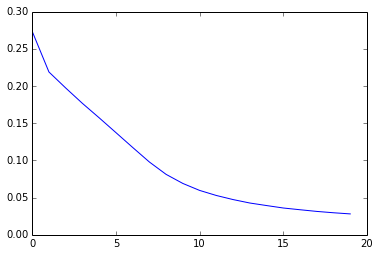

In [1454]:
plt.plot(history.history['loss'])

# Weights

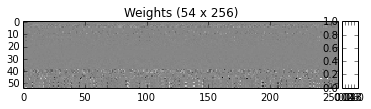

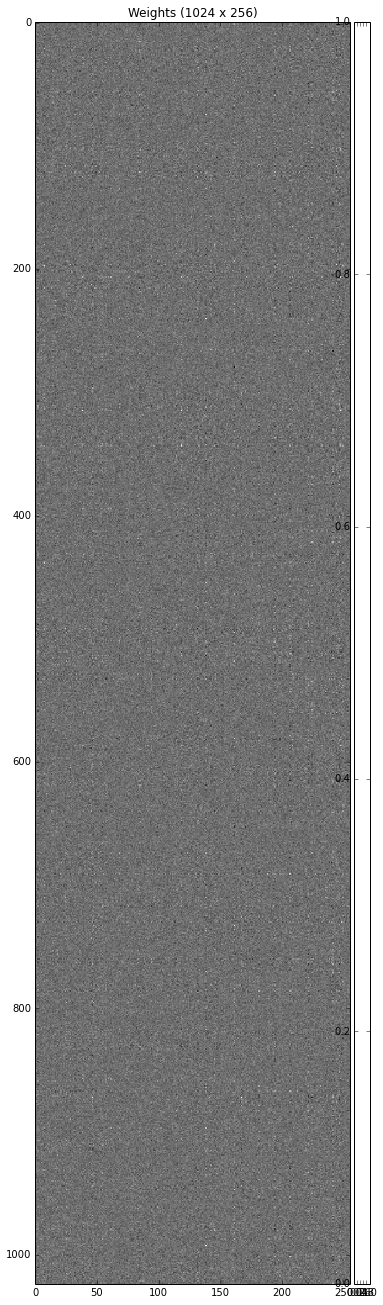

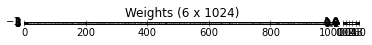

In [1455]:
W = np.squeeze(model.layers[0].W.get_value())
plt.figure()
plt.title('Weights (%d x %d)' % W.shape)
nice_imshow(plt.gca(), W)

W = np.squeeze(model.layers[1].W.get_value().T)
plt.figure(figsize=(6, 24))
plt.title('Weights (%d x %d)' % W.shape)
nice_imshow(plt.gca(), W)

W = np.squeeze(model.layers[2].W.get_value().T)
plt.figure()
plt.title('Weights (%d x %d)' % W.shape)
nice_imshow(plt.gca(), W)

# Graph

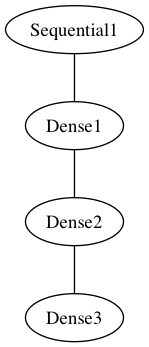

In [1456]:
from keras.utils.dot_utils import Grapher
from IPython.display import Image

grapher = Grapher()
grapher.plot(model, 'model.png')

Image(filename='model.png') 